In [1]:
import os
###########################################
# set path to the downloaded UOTReg folder
###########################################
folder_path = '/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/'
os.chdir(folder_path)
print("Current working directory:", os.getcwd())

# basic math package
import pandas as pd
import numpy as np

# loading data
import scanpy as sc

# some practical packages
import warnings
warnings.filterwarnings('ignore')
import gc
from IPython.display import clear_output

# packages for DL
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from tqdm import tqdm, tqdm_notebook
from copy import deepcopy

# package for matrix operation
from scipy.stats import ortho_group, multivariate_normal
from scipy.linalg import sqrtm
from sklearn.decomposition import PCA
from sklearn.datasets import make_spd_matrix

# load OT functions
from UOTReg.tools import ewma, freeze, unfreeze
from UOTReg import distributions
from UOTReg.models import FFNN, Seperate_D, Seperate_T, Gnet, Encoder, Discriminator
from UOTReg.tools import tensorDataset, tensorSampler
from UOTReg.tools import weights_init, calculate_moments, calculate_weights, random_sample
from UOTReg.train_models import optimize_T_and_D, optimize_G, optimize_T_and_D_UOT_new


# for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import umap

Current working directory: /Users/binghao/Desktop/Research/OT-singlecell/UOTReg


## Metrics Setup

In [2]:
class MMD_loss(nn.Module):
    '''
    https://github.com/ZongxianLee/MMD_Loss.Pytorch/blob/master/mmd_loss.py
    '''
    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        return
    
    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.guassian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss

In [3]:
import numpy as np

def gaussian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    """
    Compute the Gaussian kernel matrix for MMD.
    Args:
        source: Source data, shape (N, d) as a NumPy array.
        target: Target data, shape (M, d) as a NumPy array.
        kernel_mul: Kernel multiplication factor.
        kernel_num: Number of Gaussian kernels.
        fix_sigma: Fixed bandwidth for Gaussian kernels (optional).
    Returns:
        Kernel matrix as a NumPy array.
    """
    n_samples = source.shape[0] + target.shape[0]
    total = np.concatenate([source, target], axis=0)

    # Compute pairwise L2 distance
    total0 = np.expand_dims(total, axis=0)
    total1 = np.expand_dims(total, axis=1)
    L2_distance = np.sum((total0 - total1) ** 2, axis=2)

    # Determine bandwidth
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = np.sum(L2_distance) / (n_samples**2 - n_samples)
    bandwidth /= kernel_mul ** (kernel_num // 2)

    # Compute kernels with multiple bandwidths
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    kernel_val = [np.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]

    return sum(kernel_val)

def mmd_loss(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    """
    Compute the MMD loss between source and target distributions.
    Args:
        source: Source data, shape (N, d) as a NumPy array.
        target: Target data, shape (M, d) as a NumPy array.
        kernel_mul: Kernel multiplication factor.
        kernel_num: Number of Gaussian kernels.
        fix_sigma: Fixed bandwidth for Gaussian kernels (optional).
    Returns:
        MMD loss as a scalar.
    """
    batch_size = source.shape[0]
    kernels = gaussian_kernel(source, target, kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)

    # Split kernel matrix into blocks
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]

    # Compute MMD loss
    loss = np.mean(XX + YY - XY - YX)
    return loss

source = np.random.randn(100, 10)  # Example source data
target = np.random.randn(100, 10)  # Example target data
loss = mmd_loss(source, target)
print("MMD Loss:", loss)

# mmd = MMD_loss()
# mmd.forward(torch.from_numpy(source), torch.from_numpy(target))


MMD Loss: 0.06018317332443306


In [4]:
import numpy as np
import ot

def compute_emd(X, Y):
    """
    Compute the Earth Mover's Distance (EMD) between two distributions.

    Args:
        X: Samples from distribution P, shape (N, d).
        Y: Samples from distribution Q, shape (M, d).

    Returns:
        EMD value (scalar).
    """
    a = ot.unif(X.shape[0])  # Uniform weights for P
    b = ot.unif(Y.shape[0])  # Uniform weights for Q

    M = ot.dist(X, Y, metric='euclidean')  # Cost matrix (Euclidean distances)

    emd_value = ot.emd2(a, b, M)  # Compute EMD (squared)
    return emd_value

def compute_w2(X, Y):
    """
    Compute the Wasserstein-2 distance (W2) between two distributions.

    Args:
        X: Samples from distribution P, shape (N, d).
        Y: Samples from distribution Q, shape (M, d).

    Returns:
        W2 distance (scalar).
    """
    a = ot.unif(X.shape[0])  # Uniform weights for P
    b = ot.unif(Y.shape[0])  # Uniform weights for Q

    M = ot.dist(X, Y, metric='sqeuclidean')  # Cost matrix (squared Euclidean distances)

    w2_value = ot.emd2(a, b, M)  # Compute W2 (squared)
    return np.sqrt(w2_value)  # Take square root to get W2

def compute_w2_reg(X, Y, reg=0.1):
    """
    Compute the entropy-regularized Wasserstein-2 distance (W2-reg) between two distributions.

    Args:
        X: Samples from distribution P, shape (N, d).
        Y: Samples from distribution Q, shape (M, d).
        reg: Entropy regularization parameter.

    Returns:
        Regularized W2 distance (scalar).
    """
    a = ot.unif(X.shape[0])  # Uniform weights for P
    b = ot.unif(Y.shape[0])  # Uniform weights for Q

    M = ot.dist(X, Y, metric='sqeuclidean')  # Cost matrix (squared Euclidean distances)

    G = ot.sinkhorn(a, b, M, reg)  # Compute regularized transport plan
    w2_reg_value = np.sum(G * M)  # Regularized W2 value
    return np.sqrt(w2_reg_value)  # Take square root to get W2

np.random.seed(42)
X = np.random.randn(100, 2)  # Samples from distribution P
Y = np.random.randn(120, 2)  # Samples from distribution Q

emd_value = compute_emd(X, Y)
w2_value = compute_w2(X, Y)
w2_reg_value = compute_w2_reg(X, Y, reg=0.1)

print(f"EMD: {emd_value}")
print(f"W2: {w2_value}")
print(f"W2-reg: {w2_reg_value}")

EMD: 0.42100027870337464
W2: 0.5322915031512381
W2-reg: 0.5826974522149952


## Data Setup

In [6]:
import scanpy as sc

###########################################
# set path to the downloaded UOTReg folder
###########################################
DATASET_PATH  = '/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/'
statefate = sc.read(DATASET_PATH +  "data/timedata/scrna-statefate/invitro-hvg.h5ad")

# Note: this is the top 1000 HVGs of embryoid, already normalized to 1e4 and log1p transformed
print(statefate.shape)

# get the pandas data frame we work on
statefate_pc = statefate.obsm['X_pca'][:,0:20]
print(type(statefate_pc))
print(statefate_pc.shape)

statefate_pc_df = pd.DataFrame(
    data=statefate_pc,
    index=statefate.obs_names,               # Row index from original AnnData object
    columns=[f"PC{i+1}" for i in range(statefate_pc.shape[1])]  # Column names as PC1, PC2, ...
)

print(type(statefate_pc_df))  # Should be <class 'pandas.DataFrame'>
print(statefate_pc_df.shape)

# get the time list
cells_meta = statefate.obs
unique_time = statefate.obs['time'].unique().to_list()
print(unique_time)

(130861, 1622)
<class 'numpy.ndarray'>
(130861, 20)
<class 'pandas.core.frame.DataFrame'>
(130861, 20)
[6, 4, 2]


In [7]:
Y_time_samplers = []
datasets = []

# get diseased samplers
for id in unique_time:
    X_k = statefate_pc_df[statefate.obs['time'] == id]
    cells_k = cells_meta[cells_meta['time'] == id]
    dataset = tensorDataset(X_k,cells_k)
    print(len(dataset))
    Y_time_samplers.append(tensorSampler(dataset, device="cpu"))

54116
48496
28249


In [8]:
# loading the learned generators
size = 256
DIM = 20
dropout_rate = 0.05
G1 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G2 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
Z_sampler = distributions.StandardNormalSampler(dim=DIM, device="cpu")

print('G params:', np.sum([np.prod(p.shape) for p in G1.parameters()]))

G params: 207892


## OT/UOT on Day 4

- Visualization at Day 4

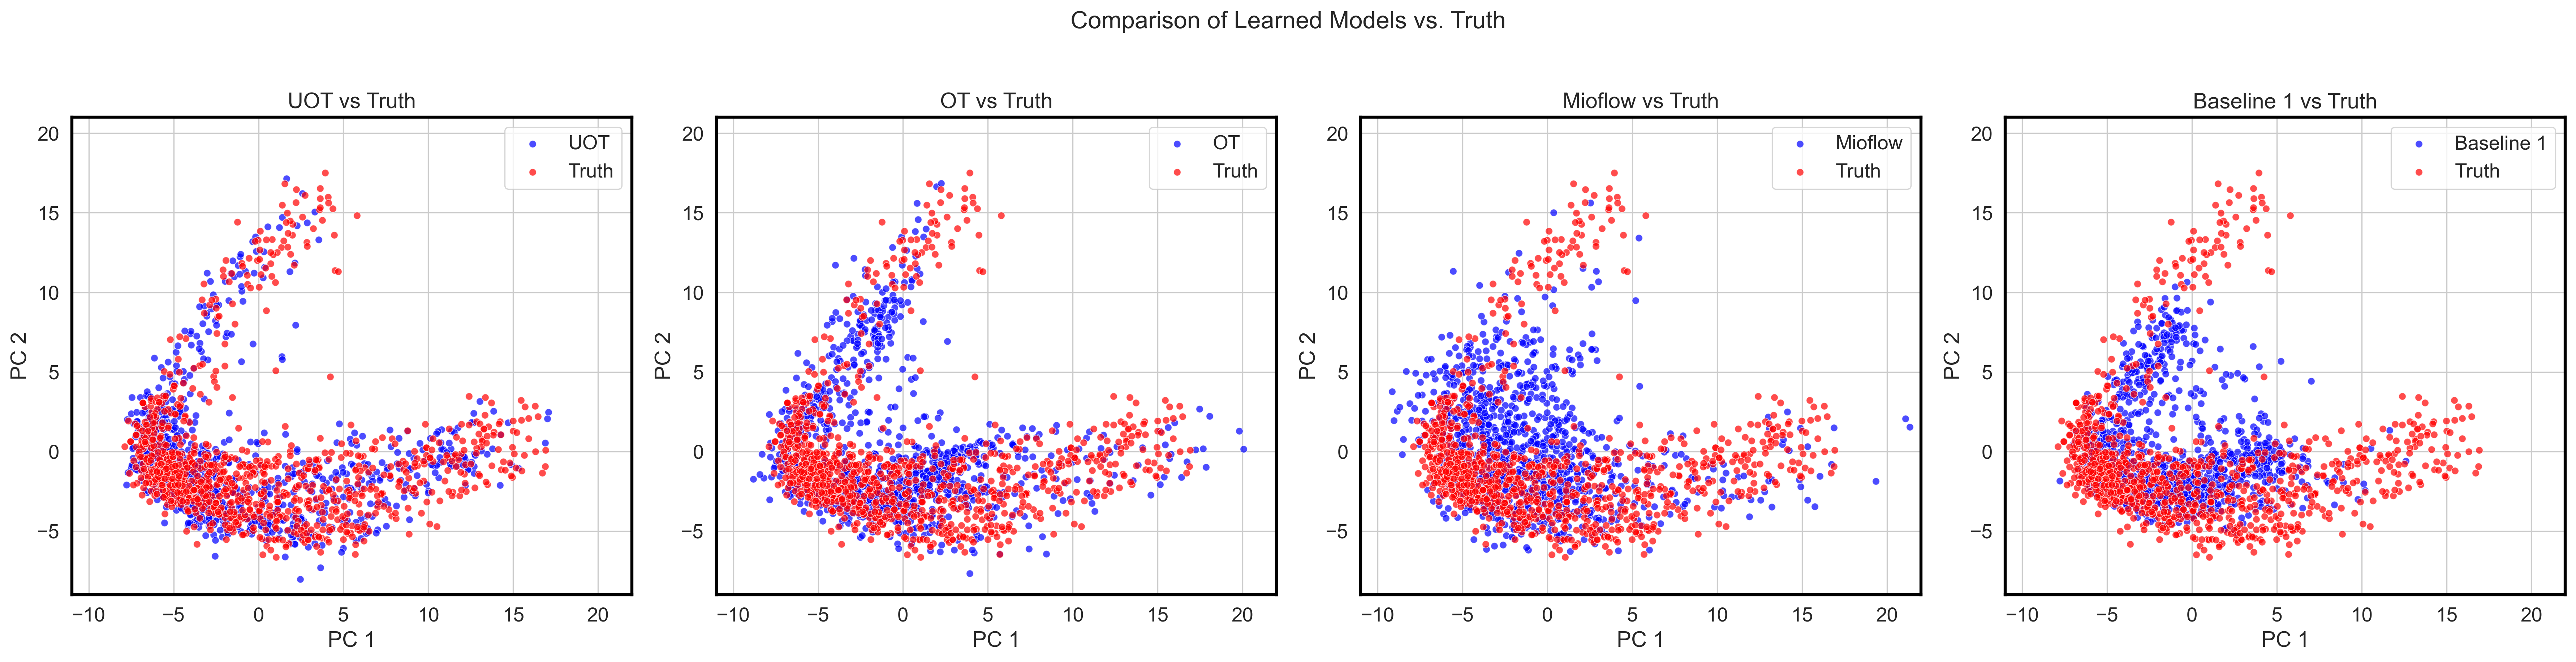

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

###########################################
# set path to the downloaded UOTReg folder
###########################################
result_folder = "/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/"
G1.load_state_dict(torch.load(result_folder+"results/dynamics/statefate/benchmark/OT/G_statefate20_256_Day4_40_new.pth"))
G2.load_state_dict(torch.load(result_folder+"results/dynamics/statefate/benchmark/UOT/G_statefate20_256_Day4_40_tau1_new.pth"))

data_baseline= (Y_time_samplers[0].sample(1000) + Y_time_samplers[2].sample(1000))/2
data_ori = Y_time_samplers[1].sample(1000).numpy()
with torch.no_grad():
    data_learned1 = G1(Z_sampler.sample(1000)).detach().numpy()
    data_learned2 = G2(Z_sampler.sample(1000)).detach().numpy()
# print(data_learned1.shape)

data_baseline = data_baseline.numpy()
data_before = Y_time_samplers[0].sample(1000).numpy()
data_next = Y_time_samplers[2].sample(1000).numpy()

# Load the Mioflow-generated data
with open(result_folder+"results/dynamics/statefate/benchmark/mioflow_new/mioflow_day4.pkl", "rb") as f:
    mioflow_data = pickle.load(f)
data_mioflow = mioflow_data[0]

# Extract the first two columns
x1, y1 = data_ori[:, 0], data_ori[:, 1]
x2, y2 = data_learned2[:, 0], data_learned2[:, 1]
x3, y3 = data_learned1[:, 0], data_learned1[:, 1]
x4, y4 = data_mioflow[:,0], data_mioflow[:,1]
x5, y5 = data_baseline[:, 0], data_baseline[:, 1]

# Set global axis limits
x_min, x_max = -11, 22
y_min, y_max = -9, 21

# Setting the style for the plot
sns.set(style="whitegrid", context="paper", font_scale=1.5)

# Create subplots with improved layout
fig, axes = plt.subplots(1, 4, figsize=(24, 6), dpi=300)

# Adjust subplot spines to make them black and thicker
for ax in axes:
    for spine in ax.spines.values():
        spine.set_color("black")  # Set spine color to black
        spine.set_linewidth(2.0)  # Adjust spine thickness

# First plot: x2, y2 vs. x1, y1
sns.scatterplot(x=x2, y=y2, color='blue', label='UOT', alpha=0.7, ax=axes[0])
sns.scatterplot(x=x1, y=y1, color='red', label='Truth', alpha=0.7, ax=axes[0])
axes[0].set_xlabel('PC 1')
axes[0].set_ylabel('PC 2')
axes[0].set_title('UOT vs Truth')
axes[0].legend()
axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)

# Second plot: x3, y3 vs. x1, y1
sns.scatterplot(x=x3, y=y3, color='blue', label='OT', alpha=0.7, ax=axes[1])
sns.scatterplot(x=x1, y=y1, color='red', label='Truth', alpha=0.7, ax=axes[1])
axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2')
axes[1].set_title('OT vs Truth')
axes[1].legend()
axes[1].set_xlim(x_min, x_max)
axes[1].set_ylim(y_min, y_max)

# Third plot: x4, y4 vs. x1, y1
sns.scatterplot(x=x4, y=y4, color='blue', label='Mioflow', alpha=0.7, ax=axes[2])
sns.scatterplot(x=x1, y=y1, color='red', label='Truth', alpha=0.7, ax=axes[2])
axes[2].set_xlabel('PC 1')
axes[2].set_ylabel('PC 2')
axes[2].set_title('Mioflow vs Truth')
axes[2].legend()
axes[2].set_xlim(x_min, x_max)
axes[2].set_ylim(y_min, y_max)

# Third plot: x5, y5 vs. x1, y1
sns.scatterplot(x=x5, y=y5, color='blue', label='Baseline 1', alpha=0.7, ax=axes[3])
sns.scatterplot(x=x1, y=y1, color='red', label='Truth', alpha=0.7, ax=axes[3])
axes[3].set_xlabel('PC 1')
axes[3].set_ylabel('PC 2')
axes[3].set_title('Baseline 1 vs Truth')
axes[3].legend()
axes[3].set_xlim(x_min, x_max)
axes[3].set_ylim(y_min, y_max)

# Add a global title and adjust layout
fig.suptitle('Comparison of Learned Models vs. Truth', y=1.02, fontsize=16)
plt.tight_layout()

# Save the figure in high resolution
# plt.savefig('comparison_plot_with_consistent_axes_and_borders.png', dpi=300, bbox_inches='tight')
plt.show()


- Run 100 iterations to compute metrics for Day 4.

In [ ]:
import numpy as np
import pickle

# Load the Mioflow-generated data
###########################################
# set path to the downloaded UOTReg folder
###########################################
result_folder = "/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/"
G1.load_state_dict(torch.load(result_folder+"results/dynamics/statefate/benchmark/OT/G_statefate20_256_Day4_40_new.pth"))
G2.load_state_dict(torch.load(result_folder+"results/dynamics/statefate/benchmark/UOT/G_statefate20_256_Day4_40_tau1_new.pth"))

with open(result_folder+"results/dynamics/statefate/benchmark/mioflow_new/mioflow_day4.pkl", "rb") as f:
    mioflow_data = pickle.load(f)

# Define the number of iterations
num_iterations = 100

# Initialize lists to store results
mmd_ot_results = []
mmd_uot_results = []
mmd_baseline_results = []
mmd_before_next_results = []

emd_ot_results = []
emd_uot_results = []
emd_baseline_results = []
emd_before_next_results = []

w2_ot_results = []
w2_uot_results = []
w2_baseline_results = []
w2_before_next_results = []

# Initialize lists to store Mioflow results
mmd_mioflow_results = []
emd_mioflow_results = []
w2_mioflow_results = []

# Loop 100 times
for i in range(num_iterations):
    print(i)
    # Sample data
    data_baseline = (Y_time_samplers[0].sample(1000) + Y_time_samplers[2].sample(1000)) / 2
    data_ori = Y_time_samplers[1].sample(1000).numpy()
    with torch.no_grad():
        data_learned1 = G1(Z_sampler.sample(1000)).detach().numpy()
        data_learned2 = G2(Z_sampler.sample(1000)).detach().numpy()

    data_baseline = data_baseline.numpy()
    data_before = Y_time_samplers[0].sample(1000).numpy()
    data_next = Y_time_samplers[2].sample(1000).numpy()

    # Compute MMD
    mmd_ot_results.append(mmd_loss(data_ori, data_learned1))
    mmd_uot_results.append(mmd_loss(data_ori, data_learned2))
    mmd_baseline_results.append(mmd_loss(data_ori, data_baseline))
    mmd_before_next_results.append((mmd_loss(data_ori, data_before) + mmd_loss(data_ori, data_next)) / 2)

    # Compute EMD
    emd_ot_results.append(compute_emd(data_ori, data_learned1))
    emd_uot_results.append(compute_emd(data_ori, data_learned2))
    emd_baseline_results.append(compute_emd(data_ori, data_baseline))
    emd_before_next_results.append((compute_emd(data_ori, data_before) + compute_emd(data_ori, data_next)) / 2)

    # Compute W2
    w2_ot_results.append(compute_w2(data_ori, data_learned1))
    w2_uot_results.append(compute_w2(data_ori, data_learned2))
    w2_baseline_results.append(compute_w2(data_ori, data_baseline))
    w2_before_next_results.append((compute_w2(data_ori, data_before) + compute_w2(data_ori, data_next)) / 2)

    data_mioflow = mioflow_data[i]
    # Compute MMD
    mmd_mioflow_results.append(mmd_loss(data_ori, data_mioflow))
    # Compute EMD
    emd_mioflow_results.append(compute_emd(data_ori, data_mioflow))
    # Compute W2
    w2_mioflow_results.append(compute_w2(data_ori, data_mioflow))


# Compute averages and standard deviations
metrics = {
    "MMD OT": (np.mean(mmd_ot_results), np.std(mmd_ot_results)),
    "MMD UOT": (np.mean(mmd_uot_results), np.std(mmd_uot_results)),
    "MMD Baseline": (np.mean(mmd_baseline_results), np.std(mmd_baseline_results)),
    "MMD Before/Next": (np.mean(mmd_before_next_results), np.std(mmd_before_next_results)),
    "EMD OT": (np.mean(emd_ot_results), np.std(emd_ot_results)),
    "EMD UOT": (np.mean(emd_uot_results), np.std(emd_uot_results)),
    "EMD Baseline": (np.mean(emd_baseline_results), np.std(emd_baseline_results)),
    "EMD Before/Next": (np.mean(emd_before_next_results), np.std(emd_before_next_results)),
    "W2 OT": (np.mean(w2_ot_results), np.std(w2_ot_results)),
    "W2 UOT": (np.mean(w2_uot_results), np.std(w2_uot_results)),
    "W2 Baseline": (np.mean(w2_baseline_results), np.std(w2_baseline_results)),
    "W2 Before/Next": (np.mean(w2_before_next_results), np.std(w2_before_next_results)),
}

# Print results
for metric, (mean_val, std_val) in metrics.items():
    print(f"{metric}: Mean = {mean_val}, Std = {std_val}")

# Compute averages and standard deviations for Mioflow
mioflow_metrics = {
    "MMD Mioflow": (np.mean(mmd_mioflow_results), np.std(mmd_mioflow_results)),
    "EMD Mioflow": (np.mean(emd_mioflow_results), np.std(emd_mioflow_results)),
    "W2 Mioflow": (np.mean(w2_mioflow_results), np.std(w2_mioflow_results)),
}

# Print Mioflow results
for metric, (mean_val, std_val) in mioflow_metrics.items():
    print(f"{metric}: Mean = {mean_val}, Std = {std_val}")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
MMD OT: Mean = 0.11623495072126389, Std = 0.00829096045345068
MMD UOT: Mean = 0.08599652349948883, Std = 0.012288827449083328
MMD Baseline: Mean = 0.23483812808990479, Std = 0.009737200103700161
MMD Before/Next: Mean = 0.2951360258460045, Std = 0.013907473671673479
EMD OT: Mean = 6.21943867037058, Std = 0.08330526920421408
EMD UOT: Mean = 5.671866743878126, Std = 0.16931776793825862
EMD Baseline: Mean = 6.747623637591601, Std = 0.07384135244887184
EMD Before/Next: Mean = 7.957316647791863, Std = 0.10196903288359052
W2 OT: Mean = 6.621892730520466, Std = 0.0985742389826957
W2 UOT: Mean = 6.114370056199499, Std = 0.227208845412881
W2 Baseline: Mean = 7.14260003049896, Std = 0.0856586945262721
W2 Before/